In [5]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit.circuit.library import QFTGate  
from qiskit_aer import AerSimulator
from qiskit_aer.primitives import Sampler as AerSampler
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt
import numpy as np
from qiskit.circuit.library.basis_change import QFT
from modules.neqr import neqr
from modules.ladder import ladder_up
from modules.enhanced_grover import filter_oracle
from modules.qsubtract import subtract
from modules.qadd import qft_adder

In [ ]:
# num_bits = 3
# intensity_bits =  2

# image = np.array([
#     [0,0,0,0,0,0,0,0],
#     [0,0,0,0,0,0,0,0],
#     [0,0,1,1,1,1,0,0],
#     [0,0,1,1,1,1,0,0],
#     [0,0,1,1,1,1,0,0],
#     [0,0,1,1,1,1,0,0],
#     [0,0,0,0,0,0,0,0],
#     [0,0,0,0,0,0,0,0]

# ])



In [7]:
num_bits = 1
intensity_bits =  2

image = np.array([
    [0,1],
     [2,3]

])



3
[0, 0, 0]
2 0
max 2
1 0
0 0


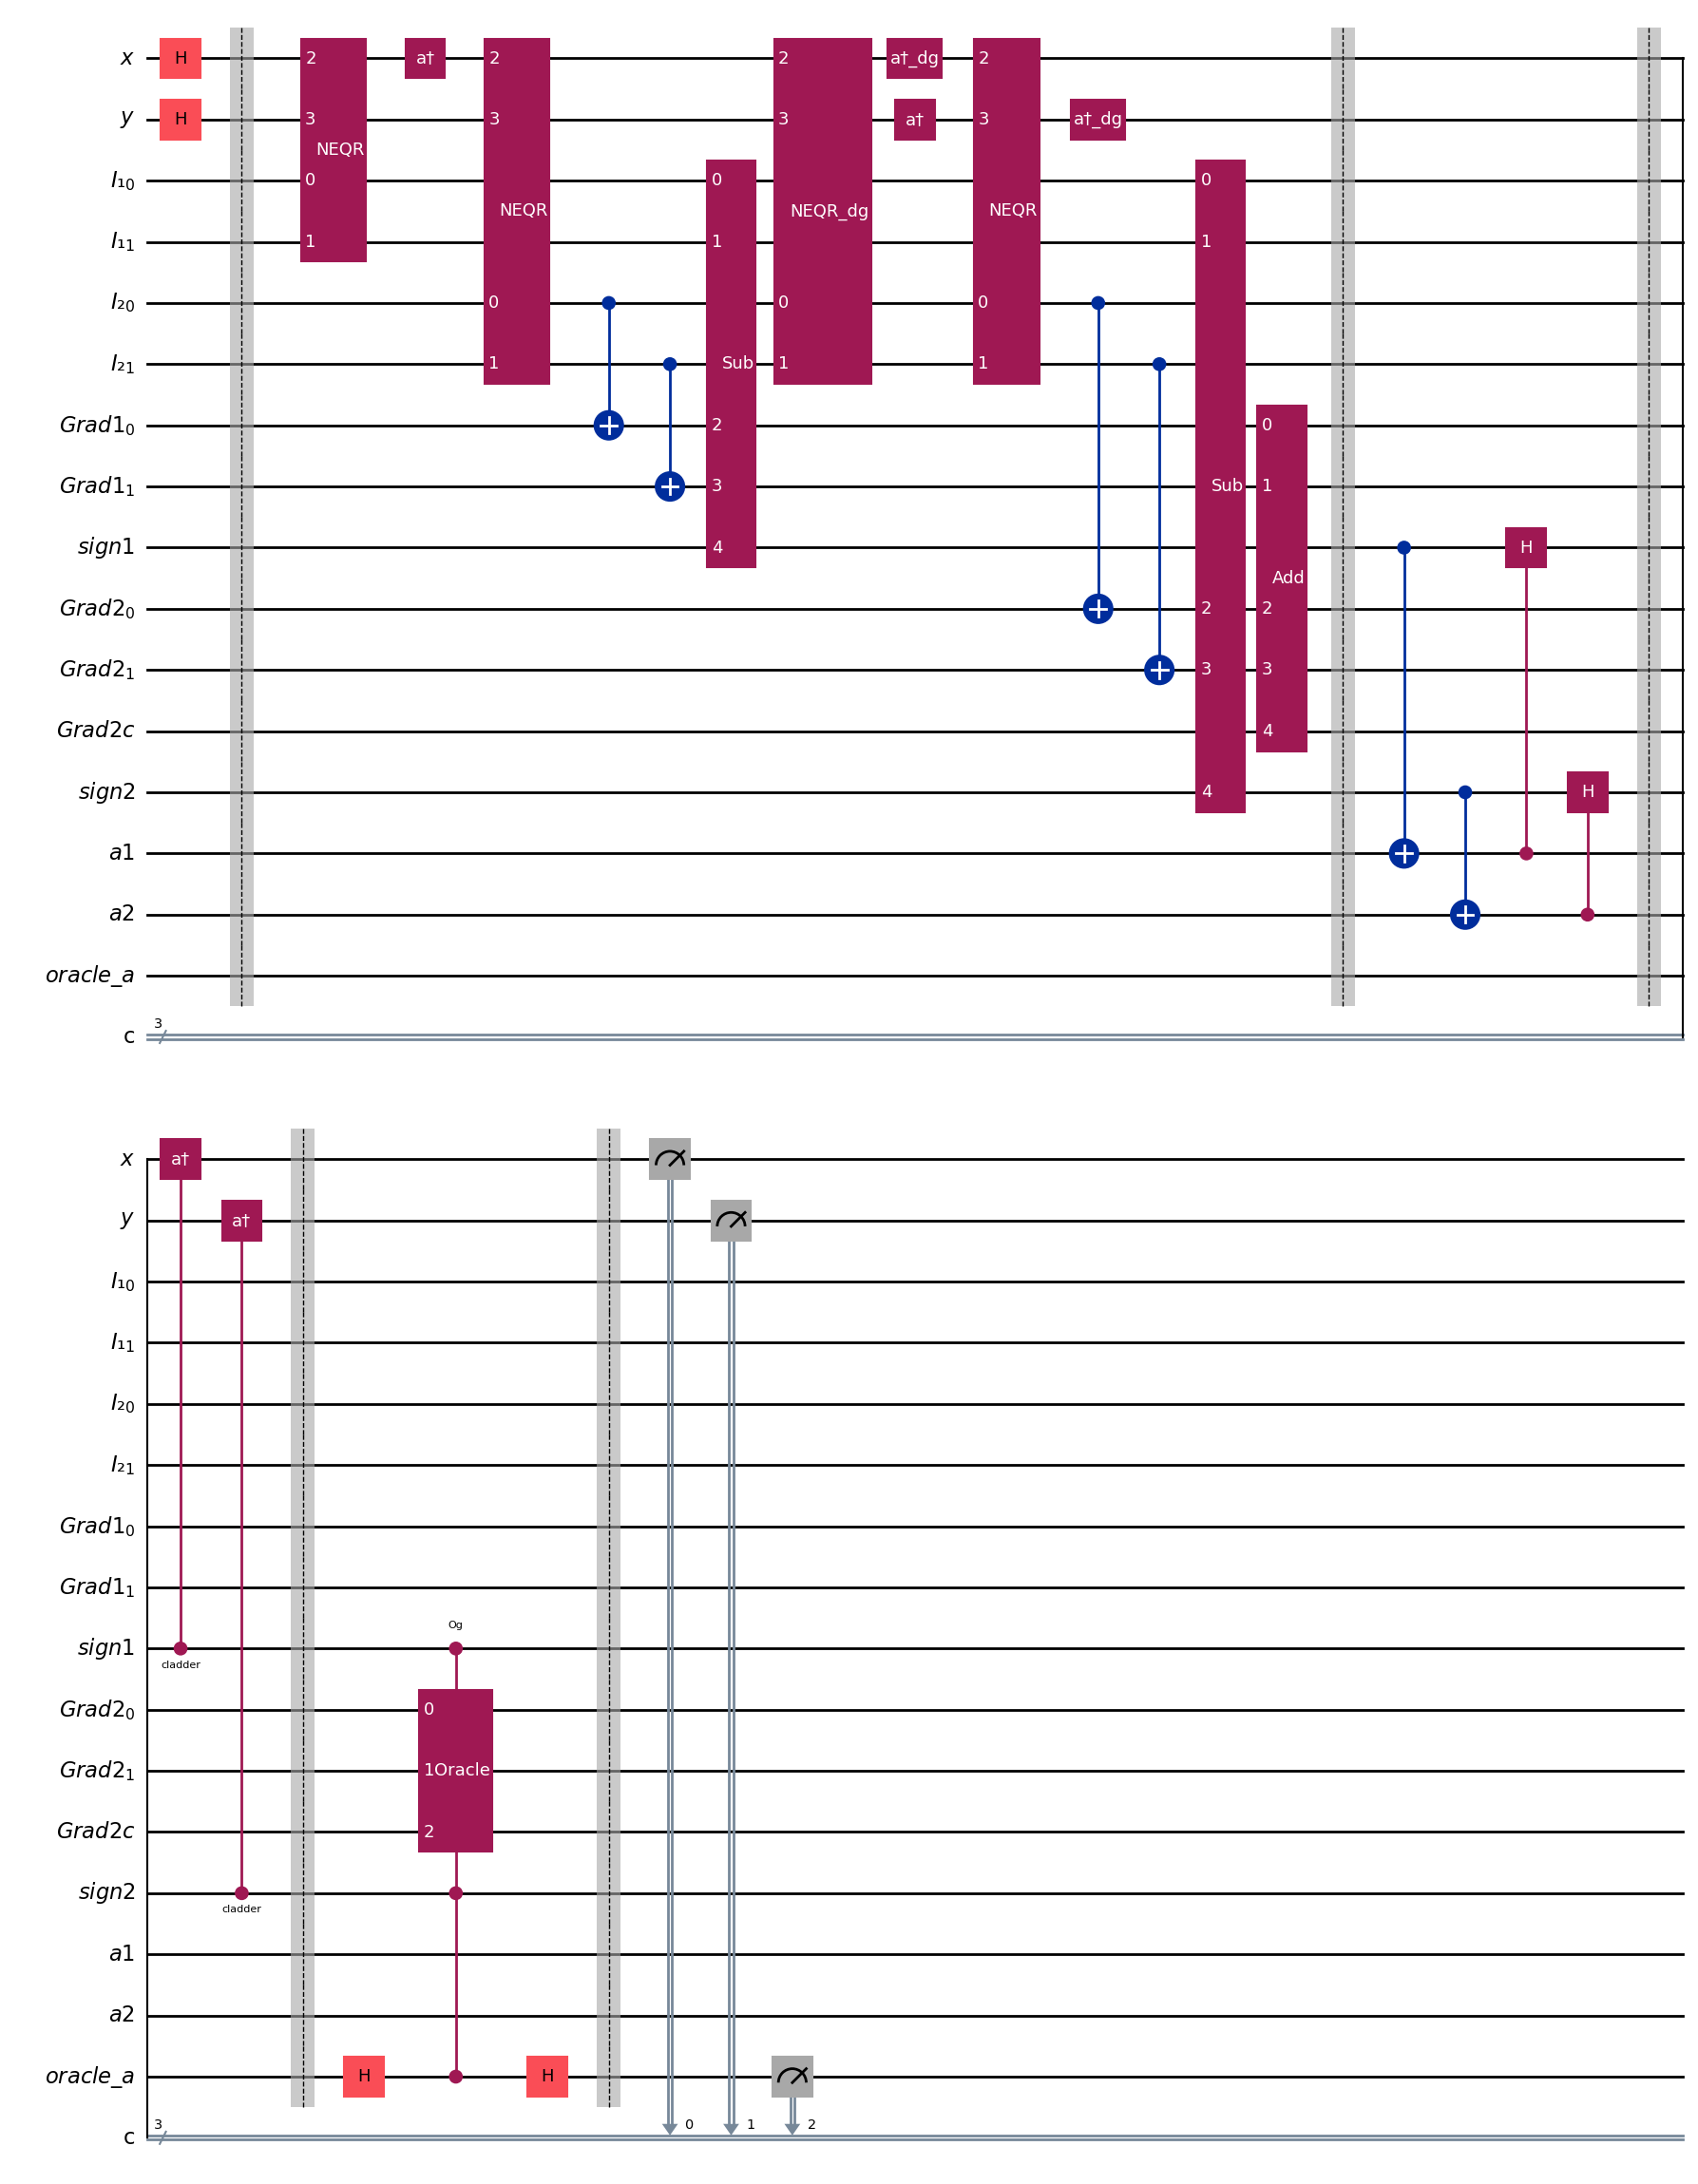

In [ ]:
x = QuantumRegister(num_bits, name='x')
y = QuantumRegister(num_bits, name='y')
i1 = QuantumRegister(intensity_bits, name='I₁')
i2 = QuantumRegister(intensity_bits, name='I₂')
grad1 = QuantumRegister(intensity_bits, name='Grad1')
oracle_a = QuantumRegister(1, name = 'oracle_a')
grad2 = QuantumRegister(intensity_bits, name='Grad2')
grad2c = QuantumRegister(1, name='Grad2c')
sign1 = QuantumRegister(1, name='sign1')
sign2 = QuantumRegister(1, name = 'sign2')
a1 = QuantumRegister(1, name='a1')
a2 = QuantumRegister(1, name='a2')
cr = ClassicalRegister(num_bits*2 + 1, name='c')

qc = QuantumCircuit(x, y, i1, i2, grad1, sign1, grad2, grad2c, sign2, a1,a2, oracle_a, cr)

qc.h(x)
qc.h(y)
qc.barrier()


neqr_gate1 = neqr(i1,x,y,image)
qc.append(neqr_gate1, list(i1) + list(x) + list(y))

# Shift up: ladder_up
ladder = ladder_up(x)
qc.append(ladder, list(x))

qc.append(neqr_gate1, list(i2) + list(x) + list(y))

qc.draw('mpl')

for i in range(intensity_bits):
    qc.cx(i2[i], grad1[i])


sub1 = subtract(i1, grad1, sign1)
qc.append(sub1, list(i1) + list(grad1) + list(sign1))

neqr1_inverse = neqr_gate1.inverse()
qc.append(neqr1_inverse, list(i2) + list(x) + list(y))

ladder_down = ladder.inverse()
qc.append(ladder_down,list(x))
qc.append(ladder, list(y))

qc.append(neqr_gate1, list(i2) + list(x) + list(y))

qc.append(ladder_down,list(y))

for i in range(intensity_bits):
    qc.cx(i2[i], grad2[i])

qc.append(sub1, list(i1) + list(grad2) + list(sign2))

add = qft_adder(grad1,grad2,grad2c)
qc.append(add, list(grad1) + list(grad2) + list(grad2c))

qc.barrier()
qc.cx(sign1,a1)
qc.ch(a1,sign1)

qc.cx(sign2,a2)
qc.ch(a2,sign2) 
qc.barrier()

ladder_control = ladder_up(x).control(1,label="cladder")


qc.append(ladder_control, list(sign1) + list(x))
qc.append(ladder_control, list(sign2) + list(y))

qc.barrier()


qc.h(oracle_a)

og = filter_oracle("000")
cog = og.control(3,label="Og")
qc.append(cog, list(oracle_a)+list(sign1)+list(sign2) + list(grad2) + list(grad2c))

qc.h(oracle_a)
qc.barrier()

qc.measure(list(x) + list(y) + list(oracle_a), list(cr))


qc.draw('mpl')

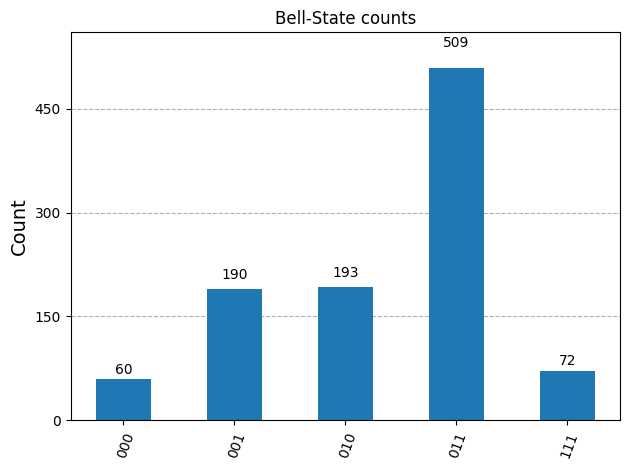

In [9]:
simulator = AerSimulator()
circ = transpile(qc, simulator)

result = simulator.run(circ).result()
counts = result.get_counts()
plot_histogram(counts, title='Bell-State counts')

In [10]:
dim = 2**num_bits
edge_img = np.zeros((dim, dim), dtype=int)
for qstate, count in counts.items():

    intensity_bin = qstate[:1]
    y_bin = qstate[1:1 + num_bits]
    x_bin = qstate[1 + num_bits:1 + 2*num_bits]

    intensity = int(intensity_bin,2)  
    y = int(y_bin, 2)
    x = int(x_bin, 2)

    edge_img[y, x] = intensity
print(edge_img)

[[0 0]
 [0 1]]
